In [241]:
%matplotlib inline
import nimfa
from collections import defaultdict, Counter
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch

In [31]:
import pandas as pd

In [54]:
## Reading the count matrix into a data frame
df_aba = pd.read_csv("aba_mat_vst.csv")

In [52]:
## dropping the first column with the name of the genes
df_aba_drop = df_aba.drop(columns=df_aba.columns[0])

In [33]:
## converting into a numpy array
d_aba = df_aba_drop.to_numpy()

In [34]:
## The dimensions of the array
m, n = d_aba.shape

## NIMFA package for NMF analysis

### Few notes about NIMFA
The block of code below shows a typical command from Nimfa library invoked to perform the non-negative matrix factorization. Here, Sparse Non-negative matrix factorization method, Snmf, is called. It tries to produce matrix decompositions with a desired level of sparsity in either of the two matrix factors.

In [446]:
## Model description
snmf = nimfa.Snmf(d_aba, seed="random_vcol", rank=20, max_iter=100, version='l',
                  eta=1., beta=1e-4, i_conv=10, w_min_change=0)
## Model fitting
snmf_fit = snmf()

In [449]:
## Accessing the left fator W from the fitted model
W = snmf_fit.basis()

In [450]:
## Accessing the right factor from the fitted model
H = snmf_fit.coef()

#### The number of rows of the left factor, W, matches the number of rows of the data matrix. This equals the number of genes in our case. 

In [455]:
d_aba.shape[0] == W.shape[0]

True

#### The columns of W equals the number of basis or rank, which we specified in our model description above (equals 20 here).

In [456]:
W.shape

(16325, 20)

#### The number of columns of the right factor, H, matches the columns of the data matrix. This equals the number of treatments in our case.

In [457]:
d_aba.shape[1] == H.shape[1]

True

#### The number of rows of H equals the number of basis or rank.

In [458]:
H.shape

(20, 28)

The columns of the W matrix is shown for the first 200 genes. As mentioned before, the columns indicate the basis/rank of the decomposition and they are also non-negative. Each of the columns can be used to group the genes such that the genes within a group contribute to idiosyncratic fashion in which that group might behave across the samples. A higher value in a row for a given column indicate a higher contribution of the corresponding gene towards the signature activity pattern of that group of genes associated with the column in consideration. We can explore the behaviour of a particular group of genes by analyzing the corresponding row in the H matrix. We will postpone such exploration of the H matrix for later when we find a better decomposition in terms of the ability of the decomposition to capture the sparse features present in the expression data in a better light. 

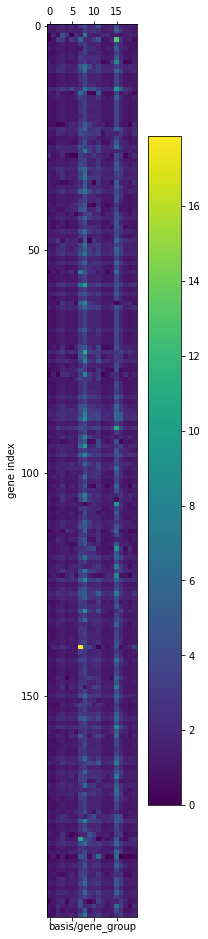

In [502]:
cb = plt.matshow(W[:200,:])
plt.colorbar()
cb.axes.set_xlabel("basis/gene_group")
cb.axes.set_ylabel("gene index")
# cb._short_axis().set_visible(True)
plt.savefig("W_sample.png",dpi=300, format="png")
plt.show()

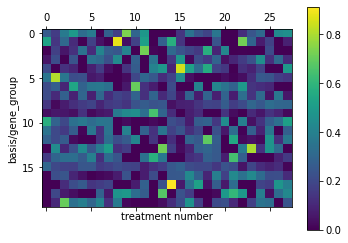

In [503]:
cb = plt.matshow(H[:,:])
plt.colorbar()
cb.axes.set_xlabel("treatment number")
cb.axes.set_ylabel("basis/gene_group")
plt.savefig("H_sample.png",dpi=300, format="png")
plt.show()

### Choosing the optimal rank parameter
We will run decompositions for a range of rank parameters and choose, based on the estimates of sparseness and reliability, the best one among them. We will continue with this chosen parameter for further analyses.


What these parameters are and what do we need from them?

rss --> residual sum-of-squares -- The sum of the squares of the deviation of the approximated values from the the original values of the input matrix they are approximating. The lesser the rss, the better. 

cophenetic correlation --> 
NMF groups genes into classes that might signal gene-clusters that work as a cohesive unit. But, it could also happen that the classes to which a gene is assigned keep changing as the initial conditions of the numerical algorithm are changed. Cophenetic correlarion measures this robustness of the groups gleaned from multiple runs of the NMF method. A cophenetic correlation close to 1 implies a gene-group assignment that withstands the assault of initial-condition changes. This can boost the confidence in the biological relevance of the group-assignment. A cophenetic correlation close to zero on the other hand either signals the presence of poor group assignments of the algorithm, which could be improved by changing the rank parameter, or a lack of structure in the expression data.

dispersion -->              

sparseness -->

explained variance -->

In [41]:
## range of rank parameters -- [3, 8, 13, 18, 23, 28]
rank_cands = range(3, 30, 5)
## Model specification
snmf = nimfa.Snmf(d_aba, seed='random_vcol', max_iter=100, version='l', beta=0.01)
## Running the function to estimate the qualities for a range of rank parameters  
summary = snmf.estimate_rank(rank_range=rank_cands, n_run=10, what='all')

In [504]:
# help(plt.savefig)

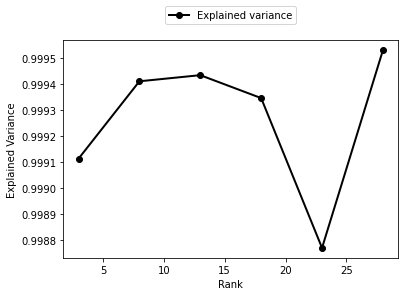

In [569]:
## Plotting the measures of quality for all the ranks we used
rss = [summary[rank]['rss'] for rank in rank_cands]
coph = [summary[rank]['cophenetic'] for rank in rank_cands]
disp = [summary[rank]['dispersion'] for rank in rank_cands]
spar = [summary[rank]['sparseness'] for rank in rank_cands]
spar_w, spar_h = zip(*spar)
evar = [summary[rank]['evar'] for rank in rank_cands]

# plt.plot(rank_cands, rss, 'o-', label='RSS', linewidth=2, color="k")
# plt.plot(rank_cands, coph, 'o-', label='Cophenetic correlation', linewidth=2)
#plt.plot(rank_cands, disp,'o-', label='Dispersion', linewidth=2, color="k")
# plt.plot(rank_cands, spar_w, 'o-', label='Sparsity (Basis)', linewidth=2)
# plt.plot(rank_cands, spar_h, 'o-', label='Sparsity (Mixture)', linewidth=2)
plt.plot(rank_cands, evar, 'o-', label='Explained variance', linewidth=2, color="k")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3, numpoints=1);
plt.ylabel("Explained Variance")
plt.xlabel("Rank")
plt.savefig("evar_vs_rank.png",dpi=300, format="png")

### NMF Decomposition with the best of the parameters
From the quality estimates we have zeroed in on rank 13 as the one that lead to sparse bases with maximum variance explained and minimum amount of errors accrued in approximating the original data matrix. We will run NMF decomposition using this parameter and will analyze the factors we obtained in detail.

In [591]:
## Model specification 
rank = 13
snmf = nimfa.Snmf(d_aba, rank=rank, seed='random_vcol', version='l', max_iter=100, beta=0.01)


In [592]:
## Fitting the model
snmf_fit = snmf()

In [507]:
## Extracting the W (with basis/gene_group as columns) matrix
W = snmf_fit.fit.basis()


In [508]:
## Extracting the H (with rows corresponding to the coeeficients of each basis/gene_group to obtain the treatment columns as a weighted sum of bases. 
H = snmf_fit.coef()

There is one to one relationship between the columns of the H matrix and the treatment columns of the original matrix. Infact, it would be instructive to view each treatment column as a weighted sum of bases in W. The weights for this sum are provided by the corresponding column of the H matrix. As we have already mentioned, each of the basis vector/column from the W matrix can be used to define a locally prominent gene-groups (the rows with the topmost values in a particular basis in W matrix). If we want to know the treatments to which a given basis/gene-group contributed heavily, we can infer it from glancing at the rows of the H matrix. For example, the basis/gene-group corresponding to the fifth column of the H matrix shown in figure.X rises in its prominence whenever the corresponding column is from one the of ABA treatments. ~This can be easily seen in another version of the same matrix where the columns are re-shuffled to group ABA and no-ABA columns~. One of the enriched gene ontology terms in this group of genes is ABA signalling validating our insight gained from glancing at the row of H.


In another example, the gene-group corresponding to the 10th row of the H matrix is enriched for gene-ontology term "vegetative-to-reproductive state" transition. Accordingly the numerical value of the row increases over time and is strongly emphasized at the later time points.




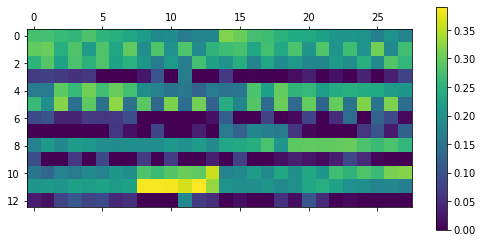

In [509]:
plt.matshow(H[:,:])
plt.colorbar()
plt.show()

For better interpretation of the H matrix, we can permute the columns

In [541]:
aba_ind = list(range(0,28,2)) 
no_aba_ind = list(range(1,28,2))
a_ind_f = aba_ind[:int(len(aba_ind)/2)]
a_ind_s = aba_ind[int(len(aba_ind)/2):]
em = []
for i,j in zip(a_ind_f,a_ind_s):
    em.extend([i,j])
aba_ind = em

na_ind_f = no_aba_ind[:int(len(no_aba_ind)/2)]
na_ind_s = no_aba_ind[int(len(no_aba_ind)/2):]
em = []
for i,j in zip(na_ind_f,na_ind_s):
    em.extend([i,j])
no_aba_ind = em

print(aba_ind)
print(no_aba_ind)
new_ind = aba_ind
new_ind.extend(no_aba_ind)
print(new_ind)

[0, 14, 2, 16, 4, 18, 6, 20, 8, 22, 10, 24, 12, 26]
[1, 15, 3, 17, 5, 19, 7, 21, 9, 23, 11, 25, 13, 27]
[0, 14, 2, 16, 4, 18, 6, 20, 8, 22, 10, 24, 12, 26, 1, 15, 3, 17, 5, 19, 7, 21, 9, 23, 11, 25, 13, 27]


Early Response 

The cluster to which the sample are assigned

In [542]:
H_new = H[:,new_ind]

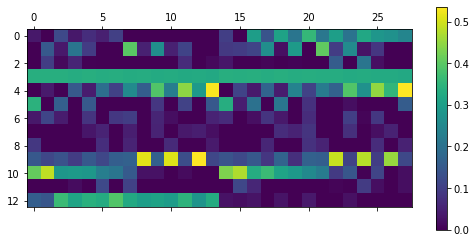

(array([0]), array([10]))
(array([0]), array([10]))
(array([0]), array([12]))
(array([0]), array([3]))
(array([0]), array([12]))
(array([0]), array([3]))
(array([0]), array([12]))
(array([0]), array([0]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([9]))
(array([0]), array([10]))
(array([0]), array([10]))
(array([0]), array([3]))
(array([0]), array([10]))
(array([0]), array([3]))
(array([0]), array([3]))
(array([0]), array([1]))
(array([0]), array([1]))
(array([0]), array([4]))
(array([0]), array([4]))
(array([0]), array([4]))
(array([0]), array([4]))
(array([0]), array([4]))
(array([0]), array([4]))


In [590]:
W_ne = snmf_fit.fit.basis()
H_ne = snmf_fit.coef()
plt.matshow(H_ne[:,new_ind])
plt.colorbar()
plt.show()
for column in H_ne.T:
    print(np.where(column==np.max(column)))

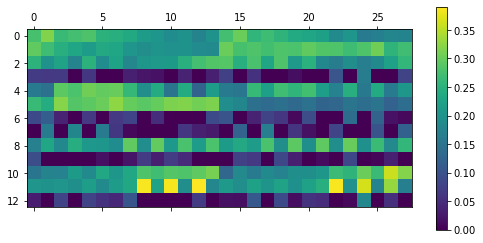

In [543]:
plt.matshow(H_new.squeeze())
plt.colorbar()
plt.show()

In [544]:
genes = df_aba['Unnamed: 0']

gene2id = {gene: idx for idx, gene in enumerate(genes)}
id2gene = dict(zip(gene2id.values(), gene2id.keys()))


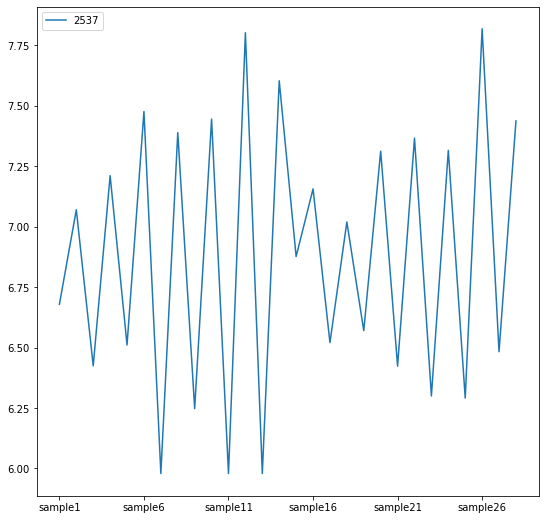

In [545]:
## Using the labels subset the original dataframe with raw expression data and plot them to check if indeed they express differently with ABA
#labels
new_labels = ['AT1G51270']
df_to_plot = df_aba[df_aba["Unnamed: 0"].isin(new_labels)]
df_to_plot_drop = df_to_plot.drop(columns=df_aba.columns[0])
ax = df_to_plot_drop.T.plot(figsize=(9,9))


In [546]:

def common_nmfBasis_pcs(basis_num, pc_num, top_k=500):
    file = open("pc{}_gene_list.txt".format(pc_num),"r")
    list_target = file.readlines()
    file.close()
    list_target_strp = []
    for ele in list_target:
        list_target_strp.append(ele.strip())

    c = basis_num
    k = top_k
    topk = np.argsort(np.asarray(W[:, c]).flatten())[-k:]
    labels = [id2gene[idx] for idx in topk]
    common_nmf_pc = set(list_target_strp) & set(labels)
    fN = open("common_pc_{}_basisNum_{}.txt".format(pc_num, basis_num),"w")
    for gen in common_nmf_pc:
        fN.write(gen)
        fN.write("\n")
    fN.close()
    return 

In [443]:
common_nmfBasis_pcs(3,6)

In [547]:
diction_to_save = {"rank_cands":rank_cands, "rss":rss, "coph":coph, 
                   "disp":disp, "spar_w":spar_w, "spar_h":spar_h,
                   "evar":evar, "best_rank":13, "best_W":W, "best_H":H}

In [ ]:
# import numpy as np

# # Save
# dictionary = {'hello':'world'}
# np.save('my_file.npy', dictionary) 

# # Load
# read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()
# print(read_dictionary['hello']) # displays "world"

In [548]:
import numpy as np

# Save
np.save('NMF_ABA_timeEvolve_summary_and_WH.npy', diction_to_save) 

In [551]:
def write_top_genes_to_file(basis_num, top_k):
    c = basis_num
    k = top_k

    topk = np.argsort(np.asarray(W[:, c]).flatten())[-k:]
    val = W[topk, c]
    # val.squeeze().shape
    # val[:,0]

    #print([float(x) for x in val])

    #plt.barh(np.arange(k) + .5, [float(x) for x in val], align="center")
    # labels = [id2gene[idx] for idx in topk]
    # plt.yticks(np.arange(k) + .5, labels)
    # plt.xlabel("Weight")
    # plt.ylabel("Gene");
    labels = [id2gene[idx] for idx in topk]
    # plt.yticks(np.arange(k) + .5, labels)
    # plt.xlabel("Weight")
    # plt.ylabel("Gene");
    fN = "gene_basis_{}_top{}.txt".format(c,k)
    fileObj = open(fN, "w")
    for ele in labels:
        fileObj.write(ele)
        fileObj.write("\n")
    fileObj.close()
    print("Written to file {}".format(fN))

In [552]:
l_bnum = list(range(0,13))
top_k = 400

for basis_num in l_bnum:
    write_top_genes_to_file(basis_num, top_k)


Written to file gene_basis_0_top400.txt
Written to file gene_basis_1_top400.txt
Written to file gene_basis_2_top400.txt
Written to file gene_basis_3_top400.txt
Written to file gene_basis_4_top400.txt
Written to file gene_basis_5_top400.txt
Written to file gene_basis_6_top400.txt
Written to file gene_basis_7_top400.txt
Written to file gene_basis_8_top400.txt
Written to file gene_basis_9_top400.txt
Written to file gene_basis_10_top400.txt
Written to file gene_basis_11_top400.txt
Written to file gene_basis_12_top400.txt


In [232]:
rank = 13
nmf = nimfa.Snmf(d_aba, rank=rank, seed='random_vcol', max_iter = 200, n_run=50, track_factor=True, consensus=True, version='l')
nmf_fit = nmf()



### The later time-point samples can be distinguished reliably from gene-group activity patterns 

The H matrix factor we got from the NMF factorization can be used to group or cluster the samples. But, The NMF is sensitive to changes in initial conditions and thus can lead to different factorization approximations on each run. Thus, a consistent group identity throughout these run would imply an inherent activity of genes most likely to influence the behaviour across the samples in the group. We are interested in arriving at such biologically relevant sample-clusters, i.e, sample-clusters defined by predominance of certain gene-groups that exclusively underpin the response/phenotype in those samples. 

The sample clusters that are robust to initial condition changes can be inferred from a summary of group identities as reflected in a consensus matrix shown in Fig.X. Here, the samples that stick together are grouped using hierarchical clustering  
The clustering achieved via multiple runs of the NMF algorith for different intial conditions show that the samples taken at a later time point (at 12,24 and 60 hours) tend to cluster very reliably. 

How does NMF cluster samples? and what does it tell us?




/tmp/ipykernel_45158/1438619510.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(C, method='average')


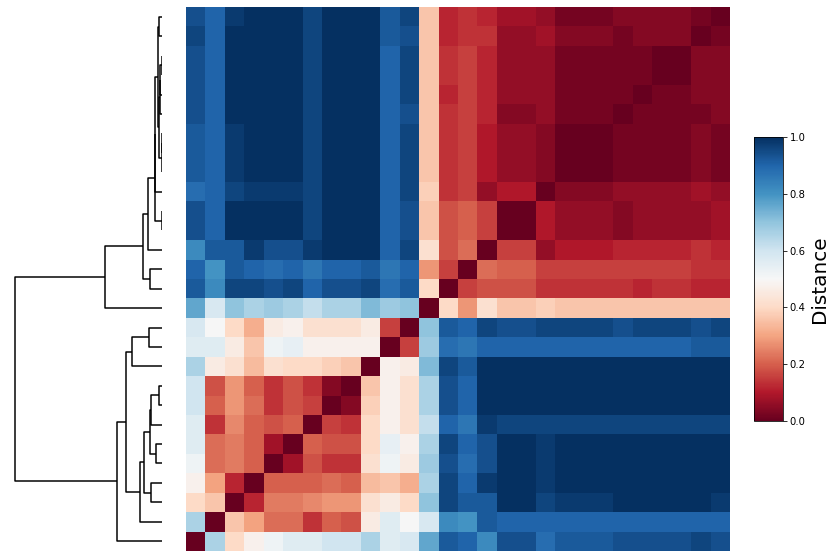

In [233]:
def clean_axis(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)

fig = plt.figure(figsize=(13.9, 10))
heatmapGS = gridspec.GridSpec(1, 2, wspace=.01, hspace=0., width_ratios=[0.25,1])

C = 1 - nmf_fit.fit.consensus()
Y = sch.linkage(C, method='average')

denAX = fig.add_subplot(heatmapGS[0,0])
denD = sch.dendrogram(Y, orientation='left', link_color_func=lambda k: 'black')
clean_axis(denAX)

heatmapAX = fig.add_subplot(heatmapGS[0,1])
D = C[denD['leaves'], :][:, denD['leaves']]
axi = heatmapAX.imshow(D, interpolation='nearest', aspect='equal', origin='lower', cmap='RdBu') 
clean_axis(heatmapAX)

cb = fig.colorbar(axi, fraction=0.046, pad=0.04, aspect=10) 
cb.set_label('Distance', fontsize=20)

In [571]:
denD

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [45.0, 45.0, 55.0, 55.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [50.0, 50.0, 72.5, 72.5],
  [30.0, 30.0, 61.25, 61.25],
  [15.0, 15.0, 45.625, 45.625],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [30.3125, 30.3125, 102.5, 102.5],
  [5.0, 5.0, 66.40625, 66.40625],
  [135.0, 135.0, 145.0, 145.0],
  [165.0, 165.0, 175.0, 175.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [225.0, 225.0, 242.5, 242.5],
  [202.5, 202.5, 233.75, 233.75],
  [265.0, 265.0, 275.0, 275.0],
  [218.125, 218.125, 270.0, 270.0],
  [185.0, 185.0, 244.0625, 244.0625],
  [170.0, 170.0, 214.53125, 214.53125],
  [155.0, 155.0, 192.265625, 192.265625],
  [140.0, 140.0, 173.6328125, 173.6328125],
  [125.0, 125.0, 156.81640625, 156.81640625],
  [35.703125, 35.703125, 140.908203125, 140.908203125]],
 'dcoord': [[0.0, 0.2932575659723037, 0.2932575659723037, 0.0],

In [236]:
from goatools import obo_parser

In [238]:
#!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a0f82ff65c76077c36edc641ba25d5ebf31e9ed32c3c328b7797b35639fdfcba
  Stored in directory: /home/arun/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [354]:
import wget 
import os 
import gzip
import Bio.UniProt.GOA as GOA
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj
from IPython.display import Image

In [240]:
go_obo_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
data_folder = os.getcwd() + "/data"

In [338]:
from goatools.obo_parser import GODag
obodag = GODag("data/go-basic.obo")
            

data/go-basic.obo: fmt(1.2) rel(2023-07-27) 46,356 Terms


In [339]:
arab_uri = "http://current.geneontology.org/annotations/tair.gaf.gz"
arab_fn = arab_uri.split('/')[-1]
wget.download(arab_uri, os.path.join(data_folder,arab_fn))

 17% [............                                                            ]  1810432 / 10592663

 30% [......................                                                  ]  3252224 / 10592663

 48% [..................................                                      ]  5136384 / 10592663

 59% [..........................................                              ]  6324224 / 10592663

 71% [...................................................                     ]  7585792 / 10592663

 89% [................................................................        ]  9519104 / 10592663

100% [........................................................................] 10592663 / 10592663

'/home/arun/Documents/linAlgNotes/data/tair.gaf (1).gz'

In [344]:
arab_gaf = os.path.join(data_folder, arab_fn)
with gzip.open(arab_gaf, 'rt') as arab_gaf_fp:
    arab_funcs = {}  # Initialise the dictionary of functions
    
    # Iterate on each function using Bio.UniProt.GOA library.
    for entry in GOA.gafiterator(arab_gaf_fp):
        #print(entry)
        tair_id = entry.pop('DB_Object_ID')
        arab_funcs[tair_id] = entry

In [345]:
assoc = {}

for x in arab_funcs:
    if x not in assoc:
        assoc[x] = set()
    assoc[x].add(str(arab_funcs[x]['GO_ID']))

In [365]:

goeaobj = GOEnrichmentStudy(
        arab_funcs.keys(), # List of mouse protein-coding genes
        assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ["bonferroni"]) # defult multipletest correction method


Load  Ontology Enrichment Analysis ...
100% 43,454 of 43,454 population items found in association


In [380]:
goea_results_all = goeaobj.run_study(labels)


Runing  Ontology Analysis: current study set of 400 IDs.
100%    380 of    380 study items found in association
 95%    380 of    400 study items found in population(43454)
Calculating 4,088 uncorrected p-values using fisher_scipy_stats
   4,088 terms are associated with 43,454 of 43,454 population items
     193 terms are associated with    380 of    400 study items
  METHOD bonferroni:
       1 GO terms found significant (< 0.05=alpha) (  0 enriched +   1 purified): local bonferroni
       0 study items associated with significant GO IDs (enriched)
      17 study items associated with significant GO IDs (purified)


In [381]:
#r = goea_results_all[0]
#dir(r)
goea_results_sig = [r for r in goea_results_all if r.p_bonferroni < 0.05]

In [382]:
plot_results("nbt3102_{NS}.png", goea_results_sig)

    1 usr   1 GOs  WROTE: nbt3102_BP.png


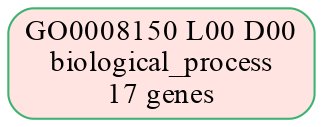

In [383]:
Image("nbt3102_BP.png")

In [364]:
help(GOEnrichmentStudy)

Help on class GOEnrichmentStudy in module goatools.go_enrichment:

class GOEnrichmentStudy(builtins.object)
 |  GOEnrichmentStudy(pop, assoc, obo_dag, propagate_counts=True, alpha=0.05, methods=None, **kws)
 |  
 |  Runs Fisher's exact test, as well as multiple corrections
 |  
 |  Methods defined here:
 |  
 |  __init__(self, pop, assoc, obo_dag, propagate_counts=True, alpha=0.05, methods=None, **kws)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_pval_uncorr(self, study, log=<ipykernel.iostream.OutStream object at 0x7fa4be1dbee0>)
 |      Calculate the uncorrected pvalues for study items.
 |  
 |  get_results_msg(self, results, study)
 |      Return summary for GOEA results.
 |  
 |  prt_tsv(self, prt, goea_results, **kws)
 |      Write tab-separated table data
 |  
 |  run_study(self, study, **kws)
 |      Run Gene Ontology Enrichment Study (GOEA) on study ids.
 |  
 |  run_study_nts(self, study, **kws)
 |      Run GOEA on study ids. Return resul